In [1]:
import torch

from torch import nn, optim
from torch.nn import functional as F

In [2]:
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature=0.1):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

In [65]:
class PMVAE(nn.Module):
    def __init__(self, n_approx=5):
        super(self.__class__, self).__init__()
        self.n_approx = n_approx
        
        self.encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.LeakyReLU(inplace=True),
            # (|mu| + |sigma| + |decision|) * num_gaussians
            nn.Linear(400, 3 * 20 * n_approx),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(20, 400),
            nn.LeakyReLU(inplace=True),
            nn.Linear(400, 784),
            nn.Sigmoid(),
        )        
        
    def encode(self, x):
        batch_size, _ = x.shape
        mu, logvar, dec = self.encoder(x).chunk(3, dim=1)
        
        mu   = mu.view(-1, 20, self.n_approx)
        logvar = logvar.view(-1, 20, self.n_approx)
        # gumbel softmax over decision matrix rows
        dec  = gumbel_softmax(dec.reshape(-1, self.n_approx)).view(-1, 20, self.n_approx)
        
        # 'choose' one component of every matrix row
        return (mu * dec).sum(2), (logvar * dec).sum(2), dec
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.Tensor.detach(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar, dec = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar, dec

In [66]:
from torchvision import datasets, transforms

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x.reshape(784)),
                       ])),
        batch_size=32, shuffle=True)

In [67]:
d_mus = torch.zeros(20, 1)
d_sigmas = torch.log(torch.ones(20, 1))

In [68]:
def kl_div(mu, logsig, m, logs):
    return 0.5 * torch.sum((logs - logsig - 1 + (logsig.exp() + (mu - m).pow(2))/logs.exp()))

def loss_function(recon_x, x, mu, logvar, dec):
    batch_size, _ = mu.shape
    
    true_mu = (d_mus[None].expand(batch_size, -1, -1) * dec).sum(2)
    true_logvar = (d_sigmas[None].expand(batch_size, -1, -1) * dec).sum(2)
    
    bce = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    kld = kl_div(mu, logvar, true_mu, true_logvar)
    
    return bce + kld

In [81]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    
    for batch_idx, (x, _) in enumerate(train_loader):
        optimizer.zero_grad()
        
        recon_x, mu, logvar, dec = model(x)
        
        loss = loss_function(recon_x, x, mu, logvar, dec)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [82]:
model = PMVAE(1)
optimizer = optim.Adam(model.parameters())

In [83]:
x = next(iter(train_loader))[0]

In [84]:
train(model, train_loader, optimizer, 1)

Train Epoch: 1 [0/60000 (0%)]	Loss: 17605.625000
Train Epoch: 1 [3200/60000 (5%)]	Loss: 6380.835449
Train Epoch: 1 [6400/60000 (11%)]	Loss: 5320.719727
Train Epoch: 1 [9600/60000 (16%)]	Loss: 5340.050781
Train Epoch: 1 [12800/60000 (21%)]	Loss: 4912.974121
Train Epoch: 1 [16000/60000 (27%)]	Loss: 4627.848145
Train Epoch: 1 [19200/60000 (32%)]	Loss: 3895.419922
Train Epoch: 1 [22400/60000 (37%)]	Loss: 3986.405518
Train Epoch: 1 [25600/60000 (43%)]	Loss: 4098.375000
Train Epoch: 1 [28800/60000 (48%)]	Loss: 4313.699219
Train Epoch: 1 [32000/60000 (53%)]	Loss: 4125.240234
Train Epoch: 1 [35200/60000 (59%)]	Loss: 3960.196289
Train Epoch: 1 [38400/60000 (64%)]	Loss: 4103.369629
Train Epoch: 1 [41600/60000 (69%)]	Loss: 3856.394287
Train Epoch: 1 [44800/60000 (75%)]	Loss: 3720.016357
Train Epoch: 1 [48000/60000 (80%)]	Loss: 3765.504395
Train Epoch: 1 [51200/60000 (85%)]	Loss: 4135.822266
Train Epoch: 1 [54400/60000 (91%)]	Loss: 3893.954346
Train Epoch: 1 [57600/60000 (96%)]	Loss: 4077.738770


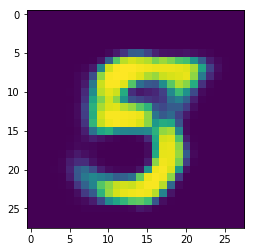

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(model.decode(torch.randn(1, 20)).view(28, 28).detach())

$$\tau \rho \iota \alpha \delta \alpha$$